# Week 2 Seminar

Top-pop recommender, metrics

In [8]:
import json
import random
import copy
from collections import namedtuple

import pandas as pd
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data = pd.read_json("/Users/darya.nikanorova/recsys_course/log/random_10k/data_seminar3.json", lines=True)
data["rnd"] = np.random.random(len(data))

data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments,rnd
0,next,2022-05-29 10:47:58.610,1984,1228,1.00,0.000977,39145.0,{'AA': 'T1'},0.516156
1,next,2022-05-29 10:47:58.619,1984,39145,0.00,0.000600,11308.0,{'AA': 'T1'},0.631624
2,next,2022-05-29 10:47:58.627,1984,11308,0.01,0.000765,28757.0,{'AA': 'T1'},0.837511
3,next,2022-05-29 10:47:58.635,1984,28757,0.00,0.000707,40694.0,{'AA': 'T1'},0.014758
4,next,2022-05-29 10:47:58.643,1984,40694,0.02,0.000620,10894.0,{'AA': 'T1'},0.280000


## Compute track popularity

In [3]:
track_popularity = (
    data[data["rnd"] > 0.5]
    .groupby("track")["time"]
    .sum()
    .to_frame()
    .sort_values("time", ascending=False)
    .reset_index()
)

track_popularity.head()

,track,time
0,2254,14.00
1,424,13.48
2,171,13.00
3,246,12.13
4,159,11.00


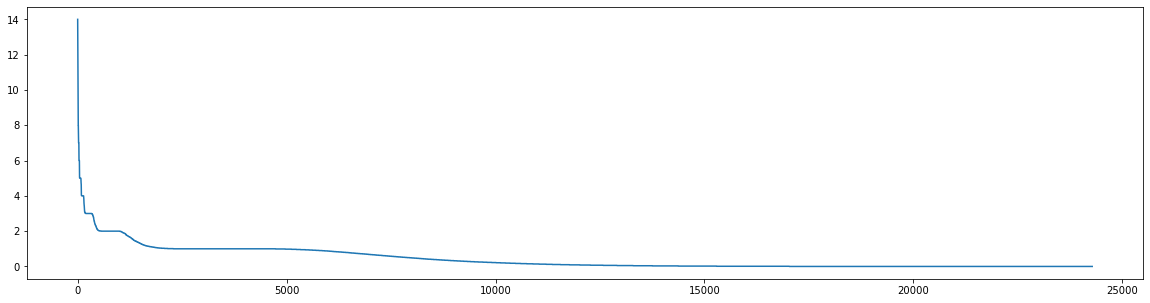

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.plot(track_popularity.index.values, track_popularity["time"].values)

## Compute offline metrics

In [5]:
tracks = track_popularity["track"].tolist()
metrics = data[(data["rnd"] <= 0.5) & (data["time"] >= 0.75)].copy()

In [20]:
def precision_at(recommendations, track, k):
    return 1.0 / k * int(track in recommendations[:k])


def shuffled_precision_at(recommendations, track, k):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return precision_at(shuffled, track, k)


# TODO 1: Implement MRR here:
def mrr(recommendations, track):
    return 1.0 / (1.0 + recommendations.index(track)) if track in recommendations else 0.0

def shuffled_mrr(recommendations, track):
    shuffled = list(recommendations)
    random.shuffle(shuffled)
    return mrr(shuffled, track)

### 1. Precision@k

In [11]:
p_10_udf = lambda track: precision_at(tracks[:10], track, 10)
sh_10_p_10_udf = lambda track: shuffled_precision_at(tracks[:10], track, 10)
sh_100_p_10_udf = lambda track: shuffled_precision_at(tracks[:100], track, 10)
sh_1000_p_10_udf = lambda track: shuffled_precision_at(tracks[:1000], track, 10)

In [12]:
metrics["p_10"] = metrics["track"].map(p_10_udf)
metrics["sh_10_p_10"] = metrics["track"].map(sh_10_p_10_udf)
metrics["sh_100_p_10"] = metrics["track"].map(sh_100_p_10_udf)
metrics["sh_1000_p_10"] = metrics["track"].map(sh_1000_p_10_udf)

In [13]:
metrics[["p_10", "sh_10_p_10", "sh_100_p_10", "sh_1000_p_10"]].describe()

,p_10,sh_10_p_10,sh_100_p_10,sh_1000_p_10
count,8322.000000,8322.000000,8322.000000,8322.000000
mean,0.000889,0.000889,0.000565,0.000192
std,0.009388,0.009388,0.007494,0.004381
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.100000,0.100000,0.100000,0.100000


### 2. MRR

In [21]:
# TODO 2: Apply MRR here:
mrr_10_udf = lambda track: mrr(tracks[:10], track)
sh_10_mrr_10_udf = lambda track: shuffled_mrr(tracks[:10], track)
sh_100_mrr_10_udf = lambda track: shuffled_mrr(tracks[:100], track)
sh_1000_mrr_10_udf = lambda track: shuffled_mrr(tracks[:1000], track)

In [22]:
metrics["mrr_10"] = metrics["track"].map(mrr_10_udf)
metrics["sh_10_mrr_10"] = metrics["track"].map(sh_10_mrr_10_udf)
metrics["sh_100_mrr_10"] = metrics["track"].map(sh_100_mrr_10_udf)
metrics["sh_1000_mrr_10"] = metrics["track"].map(sh_1000_mrr_10_udf)

In [23]:
metrics[["mrr_10", "sh_10_mrr_10", "sh_100_mrr_10", "sh_1000_mrr_10"]].describe()

,mrr_10,sh_10_mrr_10,sh_100_mrr_10,sh_1000_mrr_10
count,8322.000000,8322.000000,8322.000000,8322.000000
mean,0.002967,0.002924,0.002564,0.001259
std,0.042938,0.040915,0.030150,0.016114
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


## Export data for prod

In [24]:
with open("/Users/darya.nikanorova/recsys_course/import/top_tracks.json", "w") as top_tracks_file:
    json.dump(track_popularity["track"].tolist(), top_tracks_file)

In [25]:
len(tracks)

24280